AI club tech vertical task for round 2 by - Akshit Sharma (2025A7PS0674P)

Important note: All code is written by AI, i have only understood what has to be done and how it is working behind the scenes, it's implementation via code is not something i have knowledge of.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #used google drive to import the dataset

Mounted at /content/drive


In [ ]:
import os
drive_path = '/content/drive/MyDrive/speech_data.zip' #this part will differ if code is run

!unzip -q "{drive_path}" -d /content/ravdess_data

check_path = '/content/ravdess_data/Audio_Speech_Actors_01-24'
if os.path.exists(check_path):
    print("✅ Success! Data is extracted and ready for Phase 1.")
    print("Folders found:", os.listdir(check_path)[:5])
else:
    print("❌ Hmm, I can't find the folder. Check if the zip name or path is correct.")

✅ Success! Data is extracted and ready for Phase 1.
Folders found: ['Actor_22', 'Actor_02', 'Actor_13', 'Actor_16', 'Actor_21']


In [ ]:
#labelling each file in the audio speech folder with emotions corresponding to 3rd number in file name
import pandas as pd
import os

data_path = '/content/ravdess_data/Audio_Speech_Actors_01-24'

emotion_data = []

for actor_folder in os.listdir(data_path):
    actor_path = os.path.join(data_path, actor_folder)

    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            parts = file.split('-')
            if len(parts) > 2:
                emotion_code = parts[2]
                emotion_data.append({
                    'path': os.path.join(actor_path, file),
                    'emotion_id': int(emotion_code)
                })

df = pd.DataFrame(emotion_data)

emotion_map = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}
df['label'] = df['emotion_id'].map(emotion_map)

print(f"Total files found: {len(df)}")
print(df.head())

Total files found: 1440
                                                path  emotion_id      label
0  /content/ravdess_data/Audio_Speech_Actors_01-2...           2       calm
1  /content/ravdess_data/Audio_Speech_Actors_01-2...           7    disgust
2  /content/ravdess_data/Audio_Speech_Actors_01-2...           8  surprised
3  /content/ravdess_data/Audio_Speech_Actors_01-2...           3      happy
4  /content/ravdess_data/Audio_Speech_Actors_01-2...           2       calm


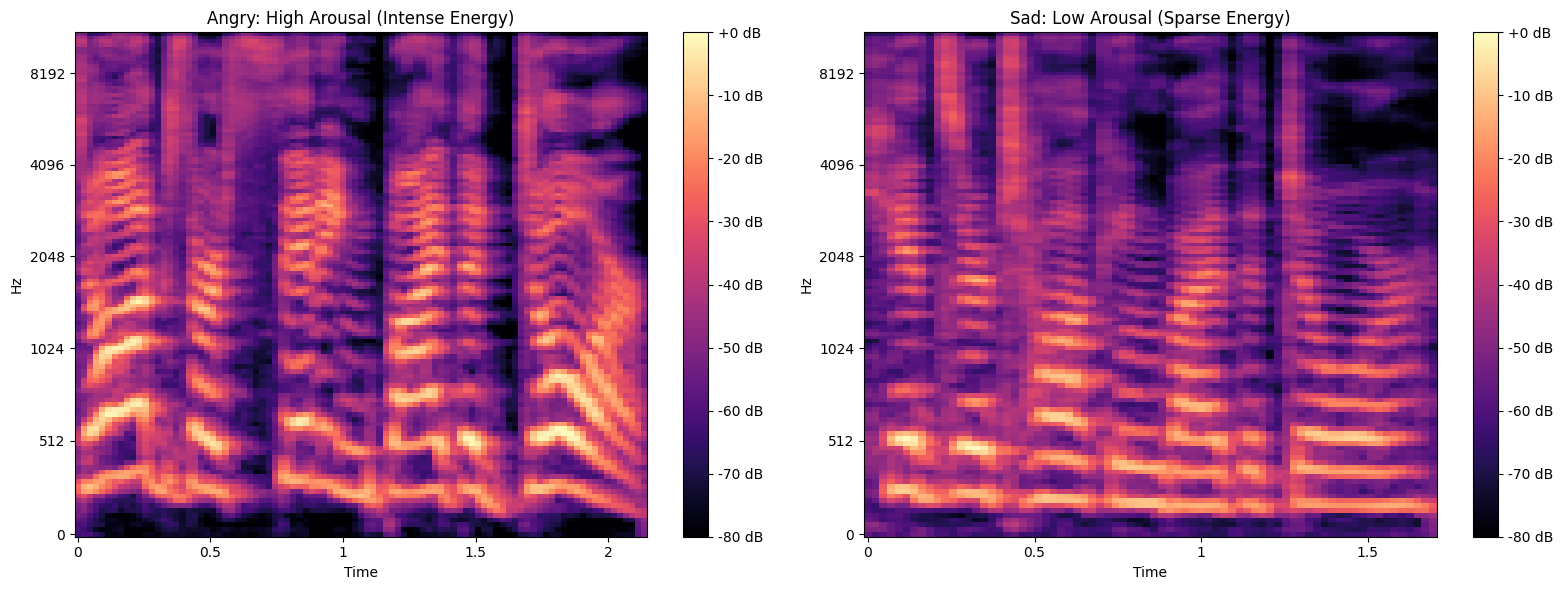

In [ ]:
#for plotting mel spectogram of 'high intensity' and 'low intensity' audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(angry_path, sad_path):
    plt.figure(figsize=(16, 6))

    y_a, sr = librosa.load(angry_path)
    y_a, _ = librosa.effects.trim(y_a, top_db=20)
    mel_a = librosa.feature.melspectrogram(y=y_a, sr=sr, n_mels=128)
    db_a = librosa.power_to_db(mel_a, ref=np.max)

    plt.subplot(1, 2, 1)
    librosa.display.specshow(db_a, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.title('Angry: High Arousal (Intense Energy)')
    plt.colorbar(format='%+2.0f dB')

    y_s, sr = librosa.load(sad_path)
    y_s, _ = librosa.effects.trim(y_s, top_db=20)
    mel_s = librosa.feature.melspectrogram(y=y_s, sr=sr, n_mels=128)
    db_s = librosa.power_to_db(mel_s, ref=np.max)

    plt.subplot(1, 2, 2)
    librosa.display.specshow(db_s, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.title('Sad: Low Arousal (Sparse Energy)')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

angry_file = df[df['label'] == 'angry']['path'].iloc[0]
sad_file = df[df['label'] == 'sad']['path'].iloc[0]

plot_comparison(angry_file, sad_file)

High intensity sounds have more bright spots towards the top of the mel spectogram and the bright spots are more consistant throughout the image, whereas the low intensity image has more black gaps in between bright spots.


In [ ]:
#removed dead silences, added padding to make spectograms of constant size and doubled the sample size by adding white noise to audios
def extract_features_with_augmentation(data, sr=22050, duration=3):
    fixed_length = sr * duration
    X, y = [], []

    print("Extracting features with Augmentation...")
    for index, row in data.iterrows():
        audio, _ = librosa.load(row['path'], res_type='soxr_hq')
        audio, _ = librosa.effects.trim(audio)

        def get_mel(sig):
            if len(sig) > fixed_length: sig = sig[:fixed_length]
            else: sig = np.pad(sig, (0, fixed_length - len(sig)), 'constant')
            mel = librosa.feature.melspectrogram(y=sig, sr=sr, n_mels=128)
            return librosa.power_to_db(mel, ref=np.max)

        X.append(get_mel(audio)[..., np.newaxis])
        y.append(row['emotion_id'] - 1)

        noise = np.random.randn(len(audio))
        noisy_audio = audio + 0.005 * noise
        X.append(get_mel(noisy_audio)[..., np.newaxis])
        y.append(row['emotion_id'] - 1)

    return np.array(X), np.array(y)

X, y = extract_features_with_augmentation(df)
print(f"Final Dataset Shape: {X.shape}")

Extracting features with Augmentation...
Final Dataset Shape: (2880, 128, 130, 1)


In [ ]:
#split above extracted data(mel spectograms) into training, validation and testing sets,
#but in a stratified manner so that all samples are homogenous (have all 8 emotions)
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.111, stratify=y_train_val, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (2304, 128, 130, 1), Val: (288, 128, 130, 1), Test: (288, 128, 130, 1)


In [ ]:
#initialized the model using Conv2D layers and implemented batch normalization, global average pooling and dropout in some layers
from tensorflow.keras import layers, models

def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model(input_shape=X_train.shape[1:], num_classes=8)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#train the model with early stopping if performing poorly on validation data (ie overfitted or memorized the data)
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.1564 - loss: 2.1914 - val_accuracy: 0.0590 - val_loss: 2.2166
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.2465 - loss: 1.8975 - val_accuracy: 0.2083 - val_loss: 1.9745
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3196 - loss: 1.7651 - val_accuracy: 0.1528 - val_loss: 2.0980
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3467 - loss: 1.7093 - val_accuracy: 0.1354 - val_loss: 3.7282
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.4074 - loss: 1.5836 - val_accuracy: 0.3403 - val_loss: 1.7060
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4025 - loss: 1.5525 - val_accuracy: 0.2639 - val_loss: 1.9555
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.4467 - loss: 1.4919 - val_accuracy: 0.2535 - val_loss: 1.9665
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.4248 - loss: 1.4421 - val_accuracy: 0.3819 - v

In [ ]:
#saved the final weights file
model_save_path = '/content/drive/MyDrive/SER_Project_Model.keras' #this part would differ

model.save(model_save_path)
print(f"✅ Model saved permanently to: {model_save_path}")

✅ Model saved permanently to: /content/drive/MyDrive/SER_Project_Model.keras


In [ ]:
#final accuracies
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"🎯 Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"🧪 Final Validation Accuracy: {final_val_acc * 100:.2f}%")

🎯 Final Training Accuracy: 95.57%
🧪 Final Validation Accuracy: 73.96%


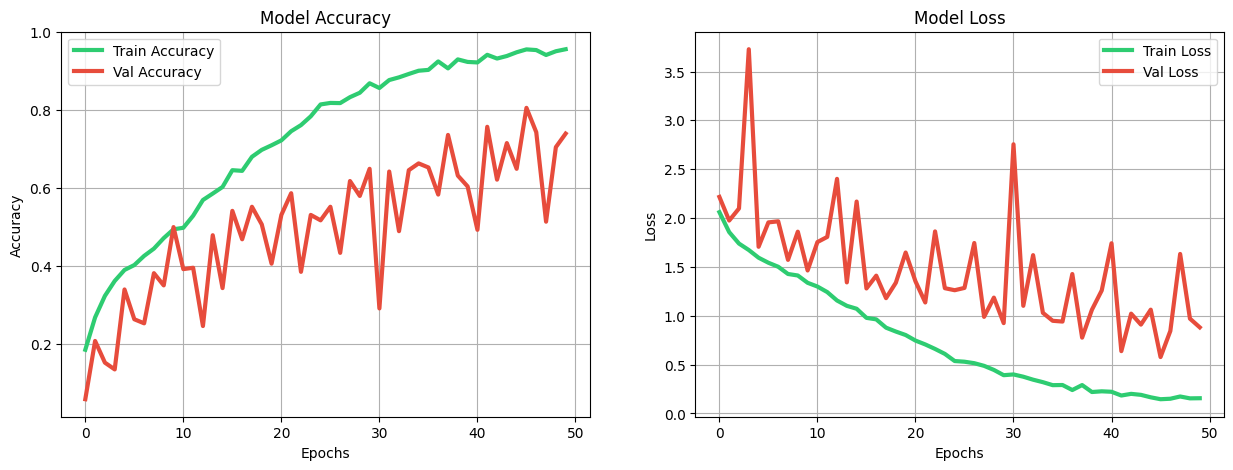

In [ ]:
#plot for accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#2ecc71', lw=3)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#e74c3c', lw=3)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='#2ecc71', lw=3)
plt.plot(history.history['val_loss'], label='Val Loss', color='#e74c3c', lw=3)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

The model is clearly overfitted with such high final accuracy and validation accuracy is fluctuating a lot.

In [ ]:
#evaluation on testing data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🔥 FINAL TEST SCORE: {test_acc * 100:.2f}%")

🔥 FINAL TEST SCORE: 79.17%


In [ ]:
#test accuracy and macro f1 score along with classification report for all emotions
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import numpy as np

y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"📢 Final Test Accuracy: {test_acc * 100:.2f}%")
print(f"📢 Macro F1-Score: {macro_f1:.4f}")
print("-" * 30)
print(classification_report(y_test, y_pred, target_names=list(emotion_map.values())))

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step
📢 Final Test Accuracy: 79.17%
📢 Macro F1-Score: 0.7725
------------------------------
              precision    recall  f1-score   support

     neutral       0.59      0.53      0.56        19
        calm       0.67      0.87      0.76        38
       happy       0.80      0.84      0.82        38
         sad       0.71      0.71      0.71        38
       angry       0.77      0.95      0.85        39
     fearful       0.85      0.85      0.85        39
     disgust       0.95      0.53      0.68        38
   surprised       1.00      0.92      0.96        39

    accuracy                           0.79       288
   macro avg       0.79      0.77      0.77       288
weighted avg       0.81      0.79      0.79       288



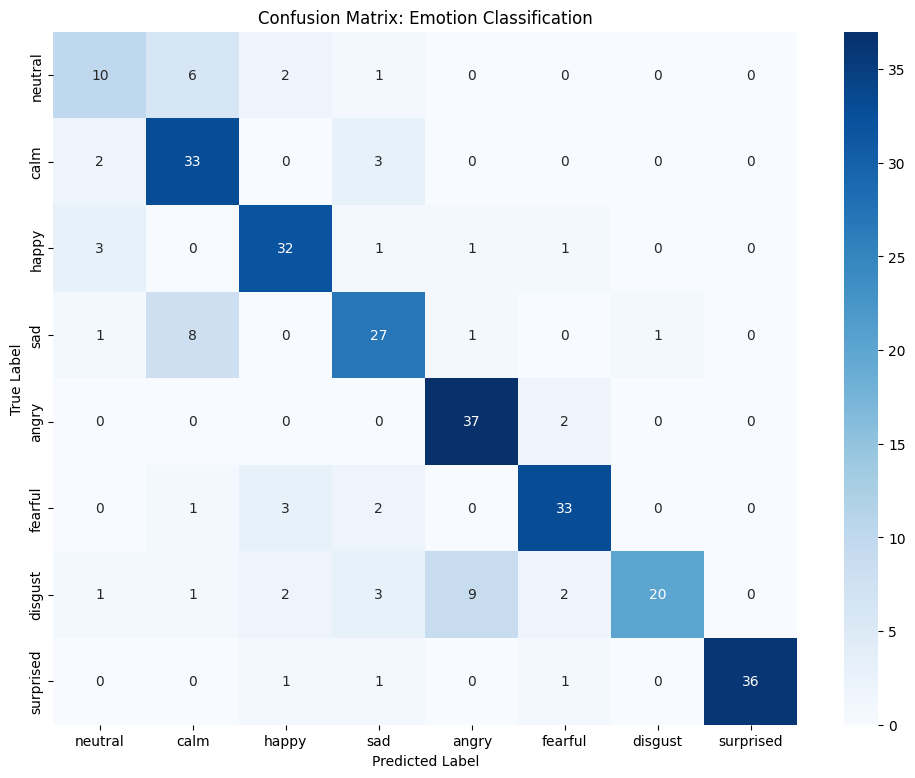

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(emotion_map.values()),
            yticklabels=list(emotion_map.values()))

plt.title('Confusion Matrix: Emotion Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#check for pitch bias, the data is laballed alternating between male and female actors
def check_pitch_bias(data, model):
    male_correct = 0
    male_total = 0
    female_correct = 0
    female_total = 0

    print("Analyzing Pitch Bias (Male vs Female)...")

    for index, row in data.sample(300).iterrows():
        actor_id = int(row['path'].split('Actor_')[-1].split('/')[0])

        y, sr = librosa.load(row['path'], res_type='soxr_hq')
        y, _ = librosa.effects.trim(y)
        fixed_length = 22050 * 3
        if len(y) > fixed_length: y = y[:fixed_length]
        else: y = np.pad(y, (0, fixed_length - len(y)))
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)[np.newaxis, ..., np.newaxis]

        pred = np.argmax(model.predict(mel_db, verbose=0))
        actual = row['emotion_id'] - 1

        if actor_id % 2 == 0:
            female_total += 1
            if pred == actual: female_correct += 1
        else:
            male_total += 1
            if pred == actual: male_correct += 1

    male_acc = (male_correct / male_total) * 100
    female_acc = (female_correct / female_total) * 100

    print(f"\n👨 Male Accuracy: {male_acc:.2f}%")
    print(f"👩 Female Accuracy: {female_acc:.2f}%")
    print(f"⚖️ Difference: {abs(male_acc - female_acc):.2f}%")

check_pitch_bias(df, model)

Analyzing Pitch Bias (Male vs Female)...

👨 Male Accuracy: 95.83%
👩 Female Accuracy: 95.51%
⚖️ Difference: 0.32%
